| Author: Remi Martin 	| Date: November 23rd 2022 	|
|---------------------	|-------------------------:	|

# Data analysis
## Dataset
The selected dataset is: **sms_spam**.

This dataset has been selected for multiple reasons:
- It is a text dataset. Previous assignement was also in NLP.
- All text may be important, and the analysis is performed on the entire text, without parsing characters or words that would be judged unecessary in regular NLP tasks.
- It is a dataset that I've never used before.
- The limited size of the dataset allows for a quick analysis, without requiring any prior sampling which is perfect for the assignement.

## Dependencies
Import the dependencies

In [1]:
from datasets import list_datasets, load_dataset
from random import sample
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy.stats import ks_2samp

## Load Dataset

In [2]:
dataset = load_dataset('SetFit/enron_spam')  

Using custom data configuration SetFit--enron_spam-dfe3f29b8d121b65
Found cached dataset json (/Users/remimartin/.cache/huggingface/datasets/SetFit___json/SetFit--enron_spam-dfe3f29b8d121b65/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
train_set = dataset['train']
test_set = dataset['test']

## Data analysis
### General information
We first try to understand what is inside the dataset: number of columns, number of rows, what exactly are the columns etc.

In [4]:
print('Number of samples in training set:', train_set.num_rows)
print('Number of samples in test set:', test_set.num_rows)
print('Dataset columns:', train_set.column_names)

Number of samples in training set: 31716
Number of samples in test set: 2000
Dataset columns: ['message_id', 'text', 'label', 'label_text', 'subject', 'message', 'date']


The columns 'label' and 'label_text' are redundant as one is an integer encoding of the label and the other one is expressed as a string.

_Examples:_

In [5]:
random_idx = sample(range(0, train_set.num_rows), 5)
print('label:', train_set[random_idx]['label'])
print('label_text:', train_set[random_idx]['label_text'])

label: [1, 0, 0, 1, 1]
label_text: ['spam', 'ham', 'ham', 'spam', 'spam']


The column 'text' is an aggregation of the columns 'subject' and 'message' seperated with a space (' ').

In [6]:
print(train_set[0]['text'] + '\n\t=\n' + train_set[0]['subject'] + '\n\t+\n' + train_set[0]['message'])

any software just for 15 $ - 99 $ understanding oem software
lead me not into temptation ; i can find the way myself .
# 3533 . the law disregards trifles .
	=
any software just for 15 $ - 99 $
	+
understanding oem software
lead me not into temptation ; i can find the way myself .
# 3533 . the law disregards trifles .


### Text analysis for spam vs ham messages

One of the assumptions for our data analysis in this section is that every character counts. Indeed, punctuation and sentence construction are often not linguistically correct in spam messages. We want through our analysis to show that behavior.

Punctuation is already seperated from the words.

#### Length of emails

In [7]:
train_set = train_set.to_pandas()
spam_msgs = train_set[train_set[:]['label'] == 1]['message']
ham_msgs = train_set[train_set[:]['label'] == 0]['message']

spam_text = train_set[train_set[:]['label'] == 1]['text']
ham_text = train_set[train_set[:]['label'] == 0]['text']

In [8]:
assert(spam_msgs.shape[0] + ham_msgs.shape[0] == train_set.shape[0])
print('Percentage of spam messages:', spam_msgs.shape[0] / train_set.shape[0] * 100, '%')

Percentage of spam messages: 50.96165973010468 %


The classification task is quite balanced with around 51% of spam messages and 49% of ham messages.

In [9]:
def number_of_words(data):
    return [len(val.split(' ')) for index, val in data.iteritems()]

nb_words_spam = number_of_words(spam_msgs)
nb_words_ham = number_of_words(ham_msgs)
print('Average number of words in spam messages:', np.average(nb_words_spam))
print('Average number of words in ham messages:', np.average(nb_words_ham))
print('Proportion:', np.average(nb_words_spam) / np.average(nb_words_ham))

Average number of words in spam messages: 232.8273216605828
Average number of words in ham messages: 330.8482607857005
Proportion: 0.7037284134656263


/var/folders/1y/clg5gc7x46l4b82v39wtd_800000gn/T/ipykernel_7867/3923574200.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return [len(val.split(' ')) for index, val in data.iteritems()]


Spam messages seem to be less wordy. However, the boxplot visualization below shows that the length of the message is not enough to differenciate between spam and ham messages. _For clarity, outliers are removed from the visualization._

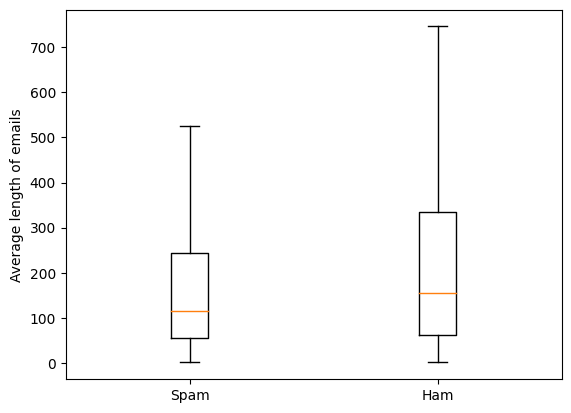

In [10]:
_, ax = plt.subplots()
ax.boxplot([nb_words_spam, nb_words_ham], labels=['Spam', 'Ham'], showfliers=False)
ax.set_ylabel('Average length of emails')
plt.show()

Observations:
- The average length (number of words) of spam emails is ~30\% lower than the average length of ham emails.
- However there's a big overlapping when plotting the distributions.

#### Length of emails' objects

In [11]:
spam_sub = train_set[train_set[:]['label'] == 1]['subject']
ham_sub = train_set[train_set[:]['label'] == 0]['subject']

nb_words_spam_sub = number_of_words(spam_sub)
nb_words_ham_sub = number_of_words(ham_sub)
print('Average number of words in spam subjects:', np.average(nb_words_spam_sub))
print('Average number of words in ham subjects:', np.average(nb_words_ham_sub))
print('Proportion:', np.average(nb_words_spam_sub) / np.average(nb_words_ham_sub))

Average number of words in spam subjects: 8.049310152818165
Average number of words in ham subjects: 6.342441972609786
Proportion: 1.269118454308229


/var/folders/1y/clg5gc7x46l4b82v39wtd_800000gn/T/ipykernel_7867/3923574200.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return [len(val.split(' ')) for index, val in data.iteritems()]


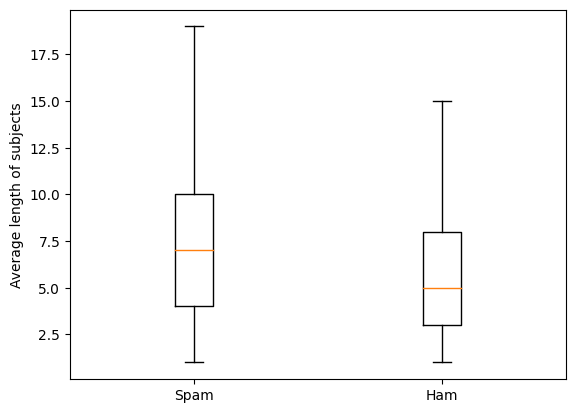

In [12]:
_, ax = plt.subplots()
ax.boxplot([nb_words_spam_sub, nb_words_ham_sub], labels=['Spam', 'Ham'], showfliers=False)
ax.set_ylabel('Average length of subjects')
plt.show()

Observations:
- The average length (number of words) of spam emails' subjects is ~27\% higher than those of ham emails.
- Big overlapping in the distributions.

#### Characters and recurrent words

We first consider single characters

In [13]:
def count_unique_chars(data, chars_only=True):
    words = data.split(' ')
    word_occurences = {}
    for w in words:
        word = w
        if w.isnumeric():
            word = "##numeric_value##"
        elif chars_only and len(w) != 1:
            continue
            
        if word in word_occurences.keys():
            word_occurences[word] += 1
        else:
            word_occurences[word] = 1
    return word_occurences

# sorted(word_occurences.items(), key=lambda item: item[1], reverse=True)

all_spam_text = spam_text.str.cat(sep=' ')
all_ham_text = ham_text.str.cat(sep=' ')

chars_dict_spam = count_unique_chars(all_spam_text)
chars_dict_ham = count_unique_chars(all_ham_text)

chars_spam = sorted(chars_dict_spam.items(), key=lambda item: item[1], reverse=True)
chars_ham = sorted(chars_dict_ham.items(), key=lambda item: item[1], reverse=True)

In [14]:
spam_chars, spam_occur = list(map(list, zip(*chars_spam)))
ham_chars, ham_occur = list(map(list, zip(*chars_ham)))

spam_freq = np.array(spam_occur) / np.sum(spam_occur)
ham_freq = np.array(ham_occur) / np.sum(ham_occur)

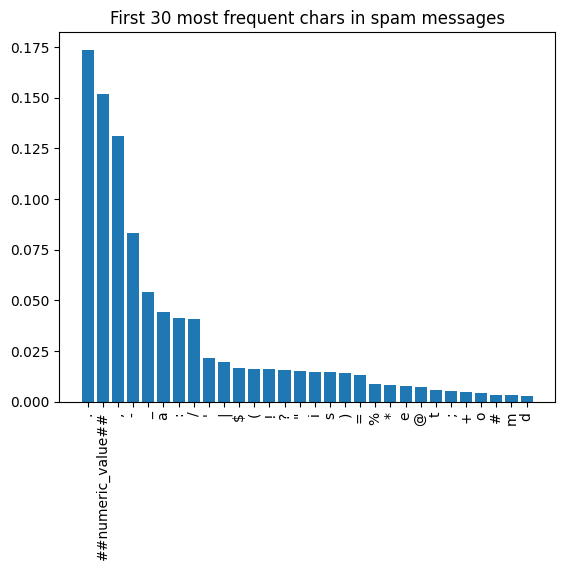

In [15]:
plt.bar(spam_chars[0:30], spam_freq[0:30]);
plt.title("First 30 most frequent chars in spam messages")
plt.xticks(rotation=90);

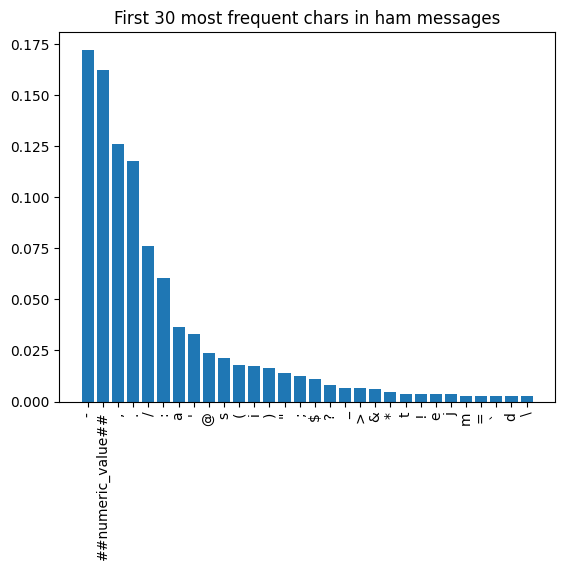

In [16]:
plt.bar(ham_chars[0:30], ham_freq[0:30]);
plt.title("First 30 most frequent chars in ham messages")
plt.xticks(rotation=90);

In [17]:
print('Proportion of numeric values contained in spam messages:', chars_dict_spam['##numeric_value##'] / np.sum(spam_occur))
print('Proportion of numeric values contained in spam messages:', chars_dict_ham['##numeric_value##'] / np.sum(ham_occur))

Proportion of numeric values contained in spam messages: 0.15162229181809753
Proportion of numeric values contained in spam messages: 0.16231688255966


Observations:
- Spam messages seem to contain more special characters such as: \+, \$
- Ham messages seem to contain a little bit more of the following characters: \@, \>
- Overall, there seem to be no big difference in the frequency of use of characters between spam and ham messages
- Spam messages do not contain more numeric values than ham messages

#### Most used words

In [18]:
# Generate word clouds
wordcloud_spam = WordCloud().generate(all_spam_text)
wordcloud_ham = WordCloud().generate(all_ham_text)

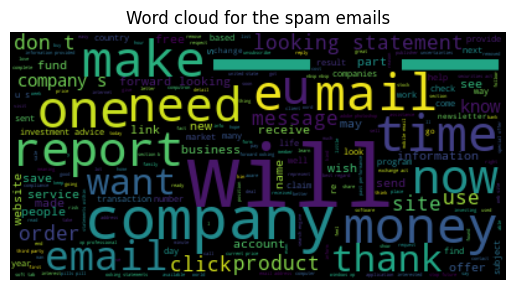

In [19]:
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.title("Word cloud for the spam emails")
plt.show()

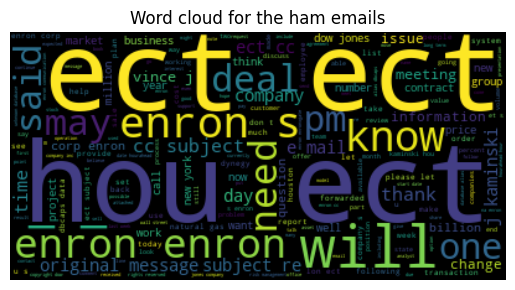

In [20]:
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis("off")
plt.title("Word cloud for the ham emails")
plt.show()

Observations:
- When looking at the cleaned word clouds (stop words removed), we can see that the most used words for the spam emails are: will, email, time, make, report, money, time
- Ham messages contain special words such as: ect, hou. Which may imply that those are more personal

## Conclusion
I have only scratched the surface of what could be extracted and analyzed from this text dataset. More could be done but the current analysis gives a good idea of how a model designed for the classification of spam messages could be built.

The most prominent discoveries are:
- Spam messages seem to be, in average, less wordy than ham messages. But plotting the distribution doesn't indicate a specific tendency that would help classify only using the size.
- The tiles of spam messages are in average longer
- The distribution of words (including stop words) and characters between the two classes is quite different.
- As would be expected of spam messages, the character "$" often appears in spam messages, but also appears in ham messages
- Suprisingly, the percentage of numeric values in spam messages (\~3.9\%) is lower than the percentage of numeric values in ham messages (\~4.8\%)
- Some characters seem to be useful to discriminate between the two classes (e.g. \+, \>, \$)
- The most used words (stopwords excluded) for both datasets are quite different. The spam emails seem to be more business/money oriented with a large presence of: money, company, report, time